In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
# import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc


# import cupy as cp

import time
# import rapids_singlecell as rsc

import warnings
import dask
import time



# from dask_cuda import LocalCUDACluster
# from dask.distributed import Client
warnings.filterwarnings("ignore")

In [6]:
adata_path = '../data/spatial_single_cell_KS_adata.h5ad'
adata = sc.read_h5ad(adata_path)

In [12]:
import numpy as np
import pandas as pd
from scipy.sparse import issparse, csr_matrix
from numba import jit, prange
import time


def extract_neighbors_from_sparse(conn_matrix, max_neighbors=90):
    """
    Extract neighbors from sparse connectivity matrix without converting to dense
    
    Parameters
    ----------
    conn_matrix : sparse matrix
        Connectivity matrix from adata.obsp
    max_neighbors : int
        Maximum number of neighbors to extract per cell
    
    Returns
    -------
    distances : array, shape (max_neighbors, n_cells)
    indices : array, shape (max_neighbors, n_cells)
    """
    if not issparse(conn_matrix):
        conn_matrix = csr_matrix(conn_matrix)
    else:
        conn_matrix = csr_matrix(conn_matrix)  # Ensure CSR format
    
    n_cells = conn_matrix.shape[0]
    distances = np.full((max_neighbors, n_cells), np.inf, dtype=np.float32)
    indices = np.zeros((max_neighbors, n_cells), dtype=np.int64)
    
    print(f"Extracting neighbors from sparse matrix ({n_cells} cells)...")
    
    # Iterate through sparse matrix efficiently
    for i in range(n_cells):
        # Get non-zero entries for cell i (its neighbors)
        start_idx = conn_matrix.indptr[i]
        end_idx = conn_matrix.indptr[i + 1]
        
        neighbor_indices = conn_matrix.indices[start_idx:end_idx]
        neighbor_weights = conn_matrix.data[start_idx:end_idx]
        
        if len(neighbor_indices) == 0:
            continue
        
        # Convert weights to distances: distance = -log(weight)
        neighbor_distances = -np.log(neighbor_weights + 1e-10)
        
        # Sort by distance (closest first)
        sorted_idx = np.argsort(neighbor_distances)
        n_keep = min(len(sorted_idx), max_neighbors)
        
        distances[:n_keep, i] = neighbor_distances[sorted_idx[:n_keep]]
        indices[:n_keep, i] = neighbor_indices[sorted_idx[:n_keep]]
        
        if (i + 1) % 10000 == 0:
            print(f"  Processed {i + 1}/{n_cells} cells...")
    
    return distances, indices


@jit(nopython=True, parallel=True)
def compute_simpson_fast(
    distances: np.ndarray,
    indices: np.ndarray,
    labels_array: np.ndarray,
    n_categories: int,
    perplexity: float,
    tol: float = 1e-5
):
    """
    Fully optimized Simpson computation with numba parallel processing
    """
    n = distances.shape[1]
    simpson = np.zeros(n, dtype=np.float64)
    logU = np.log(perplexity)
    
    # Parallel loop over cells
    for i in prange(n):
        # Count valid distances
        n_valid = 0
        for j in range(distances.shape[0]):
            if np.isfinite(distances[j, i]):
                n_valid += 1
        
        if n_valid == 0:
            simpson[i] = 1.0
            continue
        
        # Extract valid data
        valid_distances = np.empty(n_valid, dtype=np.float64)
        valid_indices = np.empty(n_valid, dtype=np.int64)
        idx = 0
        for j in range(distances.shape[0]):
            if np.isfinite(distances[j, i]):
                valid_distances[idx] = distances[j, i]
                valid_indices[idx] = indices[j, i]
                idx += 1
        
        # Binary search for beta
        beta = 1.0
        betamin = -np.inf
        betamax = np.inf
        H = 0.0
        
        for t in range(50):
            P = np.exp(-valid_distances * beta)
            P_sum = np.sum(P)
            
            if P_sum == 0:
                simpson[i] = -1.0
                break
            
            H = np.log(P_sum) + beta * np.sum(valid_distances * P) / P_sum
            Hdiff = H - logU
            
            if abs(Hdiff) < tol:
                # Normalize P
                P = P / P_sum
                
                # Compute Simpson's index
                simpson_val = 0.0
                for category in range(n_categories):
                    P_category_sum = 0.0
                    for k in range(len(valid_indices)):
                        if labels_array[valid_indices[k]] == category:
                            P_category_sum += P[k]
                    simpson_val += P_category_sum * P_category_sum
                
                simpson[i] = simpson_val
                break
            
            # Update beta
            if Hdiff > 0:
                betamin = beta
                if not np.isfinite(betamax):
                    beta *= 2.0
                else:
                    beta = (beta + betamax) / 2.0
            else:
                betamax = beta
                if not np.isfinite(betamin):
                    beta /= 2.0
                else:
                    beta = (beta + betamin) / 2.0
        
        # Handle case where convergence failed
        if H == 0:
            simpson[i] = -1.0
    
    return simpson


def compute_lisi_from_graph_sparse(
    adata,
    label_colnames: list,
    use_rep: str = 'connectivities',
    perplexity: float = 30
):
    """
    Memory-efficient LISI computation working directly with sparse matrices
    
    Parameters
    ----------
    adata : AnnData
        Annotated data object with neighbors graph in obsp
    label_colnames : list of str
        Column names in adata.obs to compute LISI for
    use_rep : str
        Key in adata.obsp for the connectivity matrix
    perplexity : float
        Perplexity parameter for LISI computation
    
    Returns
    -------
    lisi_df : DataFrame
        DataFrame with LISI scores for each cell and label
    """
    start_time = time.time()
    
    # Get connectivity matrix (keep as sparse)
    if use_rep == 'connectivities':
        conn_matrix = adata.obsp['connectivities']
    else:
        conn_matrix = adata.obsp[use_rep]
    
    n_cells = adata.shape[0]
    n_labels = len(label_colnames)
    
    print(f"Computing LISI for {n_cells} cells, {n_labels} labels")
    print(f"Sparse matrix density: {conn_matrix.nnz / (n_cells * n_cells) * 100:.2f}%")
    
    # Extract neighbors from sparse matrix
    max_neighbors = int(perplexity * 3)
    distances, indices = extract_neighbors_from_sparse(conn_matrix, max_neighbors)
    
    print(f"Neighbor extraction took {time.time() - start_time:.1f}s")
    
    # Compute LISI for each label
    print(f"Computing LISI scores...")
    metadata = adata.obs
    lisi_df = np.zeros((n_cells, n_labels), dtype=np.float32)
    
    for i, label in enumerate(label_colnames):
        label_start = time.time()
        
        labels = pd.Categorical(metadata[label])
        n_categories = len(labels.categories)
        labels_array = labels.codes.astype(np.int64)
        
        print(f"  Computing {label} LISI ({n_categories} categories)...")
        simpson = compute_simpson_fast(
            distances, indices, labels_array, n_categories, perplexity
        )
        
        # Handle invalid Simpson values
        valid_mask = simpson > 0
        lisi_df[valid_mask, i] = 1.0 / simpson[valid_mask]
        lisi_df[~valid_mask, i] = 1.0  # Default value for invalid cells
        
        print(f"    Completed in {time.time() - label_start:.1f}s")
    
    print(f"Total time: {time.time() - start_time:.1f}s")
    
    lisi_df = pd.DataFrame(lisi_df, columns=label_colnames, index=adata.obs_names)
    
    return lisi_df

In [17]:
lisi_scores = compute_lisi_from_graph_sparse(
    adata,
    label_colnames=['sample_id', 'broad_cell_types'],
    use_rep='connectivities',
    perplexity=30
)

Computing LISI for 5787888 cells, 2 labels
Sparse matrix density: 0.00%
Extracting neighbors from sparse matrix (5787888 cells)...
  Processed 10000/5787888 cells...
  Processed 20000/5787888 cells...
  Processed 30000/5787888 cells...
  Processed 40000/5787888 cells...
  Processed 50000/5787888 cells...
  Processed 60000/5787888 cells...
  Processed 70000/5787888 cells...
  Processed 80000/5787888 cells...
  Processed 90000/5787888 cells...
  Processed 100000/5787888 cells...
  Processed 110000/5787888 cells...
  Processed 120000/5787888 cells...
  Processed 130000/5787888 cells...
  Processed 140000/5787888 cells...
  Processed 150000/5787888 cells...
  Processed 160000/5787888 cells...
  Processed 170000/5787888 cells...
  Processed 180000/5787888 cells...
  Processed 190000/5787888 cells...
  Processed 200000/5787888 cells...
  Processed 210000/5787888 cells...
  Processed 220000/5787888 cells...
  Processed 230000/5787888 cells...
  Processed 240000/5787888 cells...
  Processed 25

In [20]:
lisi_scores.median()

sample_id           5.656062
broad_cell_types    1.028410
dtype: float32

In [ ]:
import numpy as np
# take a random subset for testing
bdata = adata[np.random.choice(adata.n_obs, 100000, replace=False), :]
rsc.pp.neighbors(bdata, use_rep='X_pca', n_neighbors=15)

In [ ]:
import scanpy as sc
import numpy as np
from scib_metrics.benchmark import BatchCorrection
from harmonypy import compute_lisi

# Make sure you have batch and celltype annotations
batch_key = 'sample_id'  # or 'slide_id', 'sample', etc.
label_key = 'broad_cell_types'  # your cell type annotations

# # === Method 1: Using scib-metrics (recommended) ===
from scib_metrics import ilisi_knn, clisi_knn, kbet
from scib.metrics import ilisi_graph


ilisi_scores = compute_lisi(
    bdata.obsm['X_pca'],
    bdata.obs[[batch_key, label_key]],
    [batch_key, label_key],
    perplexity=30,
)


In [9]:
np.median(ilisi_scores, axis=0)

array([5.97465157, 1.11964211])


BATCH EFFECT ASSESSMENT (Effect Size Metrics)

Total cells: 5,787,888
Number of slides: 16

[1/3] Cell type batch effects...
CELL TYPE BATCH EFFECT ASSESSMENT

Cramér's V: 0.0883
  Interpretation: Negligible association between slide and cell type

[2/3] Niche batch effects...
NICHE BATCH EFFECT ASSESSMENT

Cramér's V: 0.1454
  Interpretation: Weak association between slide and niche

[3/3] Viral detection batch effects...
VIRAL DETECTION BATCH EFFECT ASSESSMENT

Overall KSHV+ frequency: 41.17%

Eta-squared (variance explained by slide): 0.0407
  Interpretation: Small - slide explains 1-6% of variance


PUBLICATION SUMMARY TABLE
                        Metric  Value Interpretation
Cramér's V (Cell Type ~ Slide) 0.0883     Negligible
    Cramér's V (Niche ~ Slide) 0.1454           Weak
  η² (Viral Detection ~ Slide) 0.0407          Small

Generating figure...


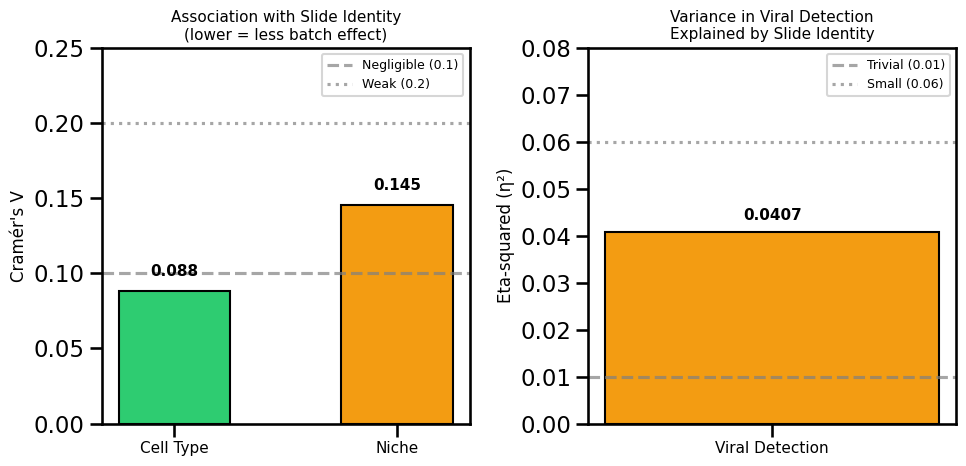

In [ ]:


import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, chi2_contingency, f_oneway
from scipy.spatial.distance import jensenshannon
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# Configuration - Update these column names as needed
# ============================================================
SLIDE_COL = 'slide_id'
CELLTYPE_COL = 'cell_type'
NICHE_COL = 'niche'
VIRAL_COL = 'KSHV_positive'

# ============================================================
# Effect Size Metrics
# ============================================================
def cramers_v(contingency_table):
    """
    Calculate Cramér's V for association between categorical variables.
    
    Interpretation:
        < 0.1: negligible association
        0.1 - 0.2: weak association
        0.2 - 0.4: moderate association
        > 0.4: strong association
    """
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    k, r = contingency_table.shape
    
    # Bias correction for large samples
    v_squared = chi2 / n
    v_squared_corrected = max(0, v_squared - ((k-1)*(r-1))/(n-1))
    k_corrected = k - ((k-1)**2)/(n-1)
    r_corrected = r - ((r-1)**2)/(n-1)
    
    cramers = np.sqrt(v_squared_corrected / min(k_corrected-1, r_corrected-1))
    return cramers

def eta_squared(data, group_col, value_col):
    """
    Calculate eta-squared: proportion of variance explained by grouping.
    
    Interpretation:
        < 0.01: trivial
        0.01 - 0.06: small
        0.06 - 0.14: medium
        > 0.14: large
    """
    groups = [group[value_col].values for name, group in data.groupby(group_col)]
    
    all_values = data[value_col].values
    grand_mean = np.mean(all_values)
    ss_total = np.sum((all_values - grand_mean) ** 2)
    ss_between = sum(len(g) * (np.mean(g) - grand_mean) ** 2 for g in groups)
    
    return ss_between / ss_total if ss_total > 0 else 0

# ============================================================
# Assessment Functions
# ============================================================
def assess_celltype_batch_effects(adata, slide_col, celltype_col):
    """Assess cell type distribution across slides using Cramér's V."""
    contingency = pd.crosstab(adata.obs[slide_col], adata.obs[celltype_col])
    cramers = cramers_v(contingency)
    
    print("=" * 70)
    print("CELL TYPE BATCH EFFECT ASSESSMENT")
    print("=" * 70)
    print(f"\nCramér's V: {cramers:.4f}")
    print("  Interpretation: ", end="")
    if cramers < 0.1:
        print("Negligible association between slide and cell type")
    elif cramers < 0.2:
        print("Weak association between slide and cell type")
    elif cramers < 0.4:
        print("Moderate association between slide and cell type")
    else:
        print("Strong association between slide and cell type")
    print("=" * 70)
    
    return {'cramers_v': cramers}

def assess_niche_batch_effects(adata, slide_col, niche_col):
    """Assess niche distribution across slides using Cramér's V."""
    contingency = pd.crosstab(adata.obs[slide_col], adata.obs[niche_col])
    cramers = cramers_v(contingency)
    
    print("=" * 70)
    print("NICHE BATCH EFFECT ASSESSMENT")
    print("=" * 70)
    print(f"\nCramér's V: {cramers:.4f}")
    print("  Interpretation: ", end="")
    if cramers < 0.1:
        print("Negligible association between slide and niche")
    elif cramers < 0.2:
        print("Weak association between slide and niche")
    elif cramers < 0.4:
        print("Moderate association between slide and niche")
    else:
        print("Strong association between slide and niche")
    print("=" * 70)
    
    return {'cramers_v': cramers}

def assess_viral_batch_effects(adata, slide_col, viral_col):
    """Assess viral detection variation across slides using eta-squared."""
    eta_sq = eta_squared(adata.obs, slide_col, viral_col)
    overall_freq = adata.obs[viral_col].mean()
    
    print("=" * 70)
    print("VIRAL DETECTION BATCH EFFECT ASSESSMENT")
    print("=" * 70)
    print(f"\nOverall KSHV+ frequency: {overall_freq:.2%}")
    print(f"\nEta-squared (variance explained by slide): {eta_sq:.4f}")
    print("  Interpretation: ", end="")
    if eta_sq < 0.01:
        print("Trivial - slide explains <1% of variance")
    elif eta_sq < 0.06:
        print("Small - slide explains 1-6% of variance")
    elif eta_sq < 0.14:
        print("Medium - slide explains 6-14% of variance")
    else:
        print("Large - slide explains >14% of variance")
    print("=" * 70)
    
    return {'eta_squared': eta_sq, 'overall_frequency': overall_freq}

# ============================================================
# Visualization
# ============================================================
def plot_effect_size_summary(celltype_results, niche_results, viral_results, 
                              save_prefix=None):
    """
    Create a summary figure with Cramér's V for cell type/niche and 
    eta-squared for viral detection.
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    colors = {'good': '#2ecc71', 'moderate': '#f39c12', 'poor': '#e74c3c'}
    
    # 1. Cramér's V for Cell Type and Niche
    ax = axes[0]
    metrics = ['Cell Type', 'Niche']
    values = [celltype_results['cramers_v'], niche_results['cramers_v']]
    bar_colors = [colors['good'] if v < 0.1 else colors['moderate'] if v < 0.2 else colors['poor'] 
                  for v in values]
    bars = ax.bar(metrics, values, color=bar_colors, edgecolor='black', linewidth=1.5, width=0.5)
    ax.axhline(y=0.1, color='gray', linestyle='--', alpha=0.7, label='Negligible (0.1)')
    ax.axhline(y=0.2, color='gray', linestyle=':', alpha=0.7, label='Weak (0.2)')
    ax.set_ylabel("Cramér's V", fontsize=12)
    ax.set_title("Association with Slide Identity\n(lower = less batch effect)", fontsize=11)
    ax.set_ylim(0, max(0.25, max(values) * 1.3))
    ax.legend(fontsize=9, loc='upper right')
    ax.tick_params(axis='x', labelsize=11)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.008, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # 2. Eta-squared for Viral Detection
    ax = axes[1]
    eta_sq = viral_results['eta_squared']
    bar_color = colors['good'] if eta_sq < 0.01 else colors['moderate'] if eta_sq < 0.06 else colors['poor']
    bars = ax.bar(['Viral Detection'], [eta_sq], color=bar_color, edgecolor='black', linewidth=1.5, width=0.4)
    ax.axhline(y=0.01, color='gray', linestyle='--', alpha=0.7, label='Trivial (0.01)')
    ax.axhline(y=0.06, color='gray', linestyle=':', alpha=0.7, label='Small (0.06)')
    ax.set_ylabel('Eta-squared (η²)', fontsize=12)
    ax.set_title('Variance in Viral Detection\nExplained by Slide Identity', fontsize=11)
    ax.set_ylim(0, max(0.08, eta_sq * 1.5))
    ax.legend(fontsize=9, loc='upper right')
    ax.tick_params(axis='x', labelsize=11)
    ax.text(0, eta_sq + 0.002, f'{eta_sq:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    
    if save_prefix:
        plt.savefig(f'{save_prefix}_effect_size_summary.pdf', bbox_inches='tight', dpi=300)
        plt.savefig(f'{save_prefix}_effect_size_summary.png', bbox_inches='tight', dpi=300)
    
    plt.show()
    return fig


def generate_table(celltype_results, niche_results, viral_results):
    """Generate a summary table."""
    summary = {
        'Metric': [
            "Cramér's V (Cell Type ~ Slide)",
            "Cramér's V (Niche ~ Slide)",
            "η² (Viral Detection ~ Slide)"
        ],
        'Value': [
            f"{celltype_results['cramers_v']:.4f}",
            f"{niche_results['cramers_v']:.4f}",
            f"{viral_results['eta_squared']:.4f}"
        ],
        'Interpretation': [
            'Negligible' if celltype_results['cramers_v'] < 0.1 else 'Weak' if celltype_results['cramers_v'] < 0.2 else 'Moderate',
            'Negligible' if niche_results['cramers_v'] < 0.1 else 'Weak' if niche_results['cramers_v'] < 0.2 else 'Moderate',
            'Trivial' if viral_results['eta_squared'] < 0.01 else 'Small' if viral_results['eta_squared'] < 0.06 else 'Medium'
        ]
    }
    
    df = pd.DataFrame(summary)
    
    print("=" * 70)
    print("SUMMARY TABLE")
    print("=" * 70)
    print(df.to_string(index=False))
    print("=" * 70)
    
    return df

# ============================================================
# MAIN EXECUTION
# ============================================================
def run_batch_assessment(adata, slide_col=SLIDE_COL, celltype_col=CELLTYPE_COL,
                         niche_col=NICHE_COL, viral_col=VIRAL_COL, save_prefix=None):
    """
    Run batch effect assessment using effect size metrics.
    """
    print("\n" + "="*70)
    print("BATCH EFFECT ASSESSMENT (Effect Size Metrics)")
    print("="*70)
    print(f"\nTotal cells: {len(adata):,}")
    print(f"Number of slides: {adata.obs[slide_col].nunique()}")
    
    results = {}
    
    # Assessments
    print("\n[1/3] Cell type batch effects...")
    results['celltype'] = assess_celltype_batch_effects(adata, slide_col, celltype_col)
    
    print("\n[2/3] Niche batch effects...")
    results['niche'] = assess_niche_batch_effects(adata, slide_col, niche_col)
    
    print("\n[3/3] Viral detection batch effects...")
    results['viral'] = assess_viral_batch_effects(adata, slide_col, viral_col)
    
    # Summary table
    print("\n")
    results['summary_table'] = generate_table(
        results['celltype'], results['niche'], results['viral']
    )
    
    # Visualization
    print("\nGenerating figure...")
    results['figure'] = plot_effect_size_summary(
        results['celltype'], results['niche'], results['viral'], save_prefix
    )
    
    if save_prefix:
        results['summary_table'].to_csv(f'{save_prefix}_batch_metrics.csv', index=False)
    
    return results


# ============================================================
# Example usage
# ============================================================
results = run_batch_assessment(
    adata,
    slide_col='sample_id',
    celltype_col='broad_cell_types',
    niche_col='niches',
    viral_col='KSHV_positive',
    save_prefix='figures'
)